In [1]:
import sys
import math
import random
import networkx
import matplotlib.pyplot as plt

In [2]:
# number of locations, including the depot. The index of the depot is 0
n = 17
locations = [*range(n)]

# number of vans
K = 6
vans = [*range(K)]

# Create n random points
# Depot is located at (0,0) coordinates
random.seed(1)
points = [(0, 0)]
points += [(random.randint(0, 50), random.randint(0, 50)) for i in range(n-1)]

# Dictionary of Euclidean distance between each pair of points
# Assume a speed of 60 km/hr, which is 1 km/min. Hence travel time = distance
time = {(i, j):
        math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
        for i in locations for j in locations if i != j}

In [3]:
import pyscipopt as scip
from pyscipopt import Model, Heur, Eventhdlr, Conshdlr, quicksum, SCIP_RESULT, SCIP_EVENTTYPE, SCIP_HEURTIMING

In [32]:
m = scip.Model()

Create variables

In [33]:
x = dict()
y = dict()
z = dict()
t  = dict()
s = dict()
for i,j in time.keys():
    for k in vans:
        x[(i,j,k)] = m.addVar(vtype="B",name="x(%s,%s,%s)"%(i,j,k))
for i in locations:
    for k in vans:
        y[(i,k)] = m.addVar(vtype="B",name="y(%s,%s)"%(i,k))

for k in vans:
    z[k] = m.addVar(vtype="B",name="z(%s)"%k)

for k in vans:
    t[k] = m.addVar(vtype="C",ub=120,name="t(%s)"%k)

s = m.addVar(name="s")


Constraints

In [34]:
# 1. Van utilization constraint

for i in locations:
    if i > 0:
        for k in vans:
            m.addCons(y[(i,k)] <= z[k])


In [35]:
# 2. Travel time constraint
for k in vans:
#     m.addCons(scip.quicksum(time[i,j]*x[(i,j,k)] for i,j in time.keys() if j > 0) == t[k])
    m.addCons(scip.quicksum(time[i,j]*x[(i,j,k)] for i,j in time.keys() if j > 0) == t[k])
        

In [36]:
# 3. Visit all customers
for i in locations:
    if i > 0:
        m.addCons(scip.quicksum(y[(i,k)] for k in vans) == 1)


In [37]:
# 4. Depot constraint
m.addCons(scip.quicksum(y[(0,k)] for k in vans) >= scip.quicksum(z[k] for k in vans))

c119

In [38]:
# 5. Arriving at a customer location constraint
for j,k in y.keys():
    m.addCons(scip.quicksum(x[(i,j,k)] for i in locations if (i,j) in time.keys()) == y[(j,k)])


In [39]:
# 6. Leaving a customer location constraint
for j,k in y.keys():
    m.addCons(scip.quicksum(x[(j,i,k)] for i in locations if (i,j) in time.keys()) == y[(j,k)])


In [40]:
# 7. Breaking symmetry constraints.
for k in vans:
    if k > 0:
        m.addCons(scip.quicksum(y[(i,k-1)] for i in locations) >= scip.quicksum(y[(i,k)] for i in locations))


In [41]:
# 8. Relate the maximum travel time to the travel times of each van
for k in vans:
    m.addCons(t[k] <= s)

In [42]:
class SEC(Conshdlr):

    # method for creating a constraint of this constraint handler type
    def createCons(self, name, variables):
        model = self.model
        cons = model.createCons(self, name)
        
        # data relevant for the constraint; in this case we only need to know which
        # variables cannot form a subtour
        cons.data = {}
        cons.data['vars'] = variables
        return cons
    
    # find subtours in the graph induced by the edges {i,j} for which x[i,j] is positive
    # at the given solution; when solution is None, the LP solution is used
    def find_subtours(self, cons, solution = None):
        for k in vans:
            edges = []
            x = cons.data['vars']
            for i,j in time.keys():
                if self.model.getSolVal(solution, x[(i,j,k)]) > 0.5:
                    edges.append((i, j))

            G = networkx.Graph()
            G.add_edges_from(edges)
            components = list(networkx.connected_components(G))
#             print(k,"XXXX",len(components),components)
            if len(components) > 1:
                return components
        return []


    # checks whether solution is feasible
    def conscheck(self, constraints, solution, check_integrality,
                  check_lp_rows, print_reason, completely, **results):
        
        # check if there is a violated subtour elimination constraint
        for cons in constraints:
            if self.find_subtours(cons, solution):
                return {"result": SCIP_RESULT.INFEASIBLE}
        
        # no violated constriant found -> feasible
        return {"result": SCIP_RESULT.FEASIBLE}

    
    # enforces the LP solution: searches for subtours in the solution and adds 
    # adds constraints forbidding all the found subtours
    def consenfolp(self, constraints, n_useful_conss, sol_infeasible):
        consadded = False
        for cons in constraints:
            subtours = self.find_subtours(cons)
            # if there are subtours
            if subtours:
                x = cons.data['vars']
                for k in vans:
                    # add subtour elimination constraint for each subtour
                    for S in subtours:
                        self.model.addCons(quicksum(x[(i,j,k)] for i in S for j in S if (i,j) in time.keys()) <= len(S)-1)
                        consadded = True

        if consadded:
            return {"result": SCIP_RESULT.CONSADDED}
        return {"result": SCIP_RESULT.FEASIBLE}



    # this is rather technical and not relevant for the exercise. to learn more see 
    # https://scipopt.org/doc/html/CONS.php#CONS_FUNDAMENTALCALLBACKS
    def conslock(self, constraint, locktype, nlockspos, nlocksneg):
        pass

In [43]:
def addSubtourElimination(model, x):
    # create the constraint handler
    conshdlr = SEC()

    # Add the constraint handler to SCIP. We set check priority < 0 so that only integer feasible solutions
    # are passed to the conscheck callback
    model.includeConshdlr(conshdlr, "TSP", "TSP subtour eliminator", chckpriority = -10, enfopriority = -10)

    # create a subtour elimination constraint
    cons = conshdlr.createCons("no_subtour_cons", x)

    # add constraint to SCIP
    model.addPyCons(cons)

In [44]:
addSubtourElimination(m, x)


In [45]:
m.setObjective(100*scip.quicksum(z[k] for k in vans) + s)

In [46]:
m.optimize()

In [47]:
m.getStatus()

'optimal'

In [48]:
m.getObjVal()

305.4165478153551

In [49]:
def find_next(route,node):
    for i, j in enumerate(route):
        if node == j[0]:
            return j[1]
        

In [50]:
# Print optimal routes
for k in vans:
    route = []
    for i,j in time.keys():
        if m.getVal(x[(i,j,k)]) > 0.5:
            route.append((i,j))
    if route:
        i = 0
        print(f"Route for van {k}: {i}", end='')
        while True:
            i = find_next(route,i)
            print(f" -> {i}", end='')
            if i == 0:
                break
        print(f". Travel time: {round(m.getVal(t[k]),2)} min")

print(f"Max travel time: {round(m.getVal(s),2)}")

Route for van 0: 0 -> 3 -> 16 -> 15 -> 2 -> 7 -> 14 -> 6 -> 5 -> 13 -> 0. Travel time: 105.42 min
Route for van 1: 0 -> 9 -> 8 -> 12 -> 1 -> 10 -> 4 -> 11 -> 0. Travel time: 105.16 min
Max travel time: 105.42


[{0, 2, 3, 5, 6, 7, 13, 14, 15, 16}]


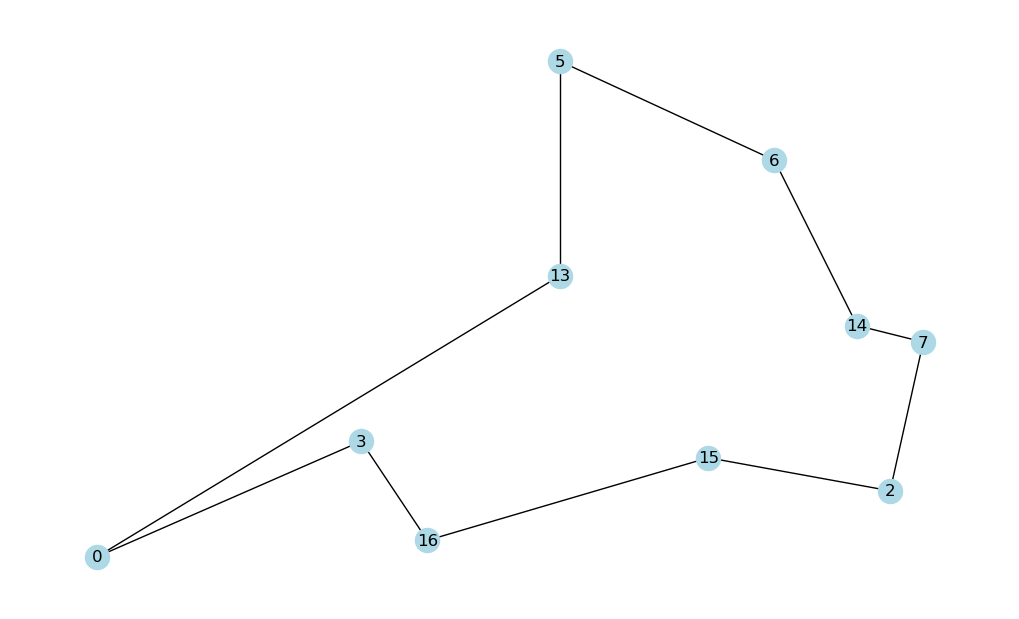

[{0, 1, 4, 8, 9, 10, 11, 12}]


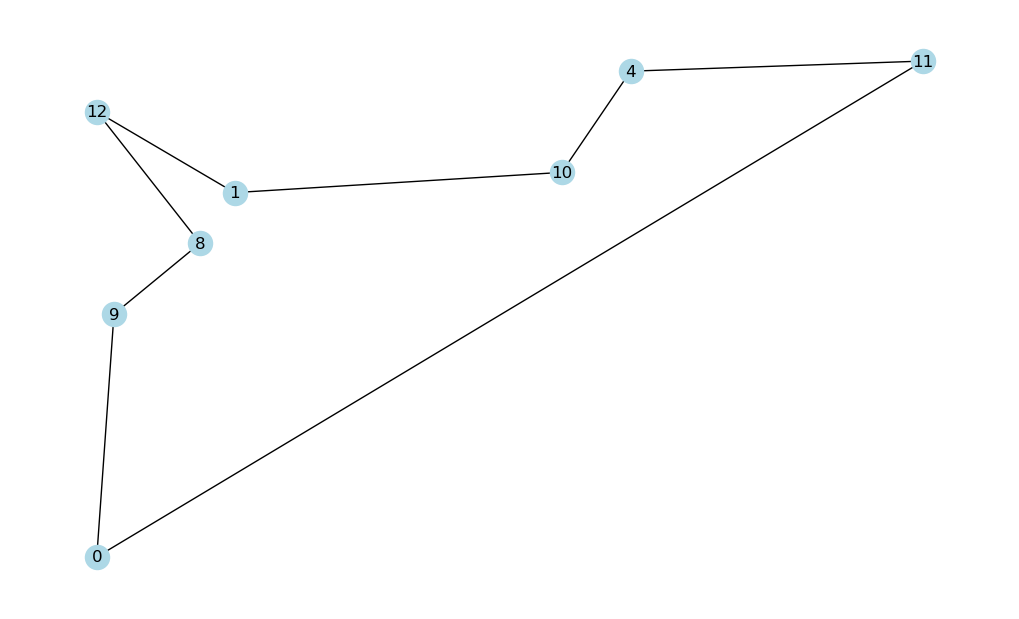

In [51]:
sol = m.getBestSol()
for k in vans:
    edges = []
    for i,j in time.keys():
        if m.getSolVal(sol, x[(i,j,k)]) > 0.5: # variable is binary so > 0.5 --> is 1
            edges.append( (i,j) )
    if edges == []:
        continue
    plt.figure(figsize=(10,6), dpi=100)
    # create empty graph
    optgraph = networkx.Graph()

    # add edges
    optgraph.add_edges_from(edges)
    components = list(networkx.connected_components(optgraph))

    print(components)
    # draw the nodes, with labels in the position xy (see when we read the instance)
    networkx.draw(optgraph, node_size=300, pos=points, with_labels=True, node_color='lightblue')

    # show drawing
    plt.show()